# Score vs N

In this notebook we plot the score, # of tests, # of FPs and # of FNs for several values of N. 

In [1]:
import os
os.chdir("../")

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
from src import utils
from src.utils import get_fig_dim
from IPython.display import clear_output
import matplotlib.pyplot as plt

sns.set_theme(context='paper', style='ticks', font_scale=1)

In [40]:
name="score_vs_N"
width_pt = 469
se = 0.8
sp = 0.98
palette = sns.color_palette('husl', 6)
type_dict = {
    'N' : int, 
    'false_negatives' : int,
    'false_positives' : int,
    'k' : float,
    'lambda_1' : float,
    'lambda_2' : float,
    'method' : str,
    'num_of_infected' : int,
    'num_of_tests' : int,
    'avg_group_size' : float,
    'r' : float,
    'score' : float,
    'se' : float,
    'sp' : float,
    'd' : float,
    'seed' : int
}

In [41]:
files = glob.glob("./outputs/{name}_*_se_{se}_sp_{sp}_*.json".format(name=name, se=se, sp=sp))

dicts = []
for fl_id, fl in enumerate(files):
    clear_output(wait=True)
    print('Reading file ' + str(fl_id+1)+'/'+str(len(files)))
    with open(fl,"r") as f:
        js = json.load(f)
        sizes = []
        for group_id in js['groups']:
            sizes.append(int(js['groups'][group_id]))

        avg_group_size = np.mean(sizes)
        
        for seed in js['seeds']:
            seed_js = js.copy()
            seed_js.pop('seeds', None)
            seed_js.pop('groups', None)    
            seed_js = seed_js | js['seeds'][seed]
            seed_js['seed']=seed
            seed_js['avg_group_size'] = avg_group_size

            dicts.append(seed_js)

input_df = pd.DataFrame(dicts)

Reading file 8/8


In [42]:
total_df = input_df.astype(type_dict) # Fix types
total_df['tests_per_contact'] = total_df['num_of_tests']/total_df['N']
total_df['fns_per_contact'] = total_df['false_negatives']/total_df['N']
total_df['fps_per_contact'] = total_df['false_positives']/total_df['N']

In [43]:
results = {}
temp = total_df[['method', 'N', 'tests_per_contact', 'fns_per_contact', 'fps_per_contact']]
binomial = temp[temp['method']=='binomial'].groupby(['N'])#.mean().reset_index()
negbin = temp[temp['method']=='negbin'].groupby(['N'])#.mean().reset_index()
results['binomial'], results['negbin'] = {}, {}
results['binomial']['avg'], results['binomial']['std'] = binomial.mean().reset_index(), binomial.std().reset_index()
results['negbin']['avg'], results['negbin']['std'] = negbin.mean().reset_index(), negbin.std().reset_index()

In [44]:
results['negbin']['std']

,N,tests_per_contact,fns_per_contact,fps_per_contact
0,20,0.396988,0.087110,0.013121
1,50,0.324793,0.055607,0.009476
2,100,0.239562,0.032215,0.006182
3,200,0.201733,0.015522,0.004749


In [45]:
# utils.latexify(font_size=10)

# fig_height, fig_aspect = get_fig_dim(width_pt, fraction=0.6)
# fig, ax = plt.subplots(figsize=(fig_height*fig_aspect,fig_height))

# # sns.pointplot(data=tests_df, x="Number of contacts", y="Number of tests per contact", hue="Method", palette=[palette[0]]+[palette[2]],
# #             ci='sd', join=False, dodge=.15, hue_order=['Dorfman', 'Algorithm 1'], capsize=.1,  ax=ax)
# # marker_size = 100
# for ind,N in enumerate([20, 50, 100, 200, 500]):
#     temp_df = tests_df[(tests_df['Method']=='Dorfman') & (tests_df['Number of contacts']==N)]
#     x = ind+1-0.1
#     y = temp_df['Number of tests per contact'].mean()
#     lower_error = temp_df['Number of tests per contact'].quantile(0.05)
#     upper_error = temp_df['Number of tests per contact'].quantile(0.95)
#     error_arr = np.zeros((2,1))
#     error_arr[0,0] = y - lower_error
#     error_arr[1,0] = upper_error - y
#     p = ax.errorbar([x], [y], yerr=error_arr, color=palette[0], fmt='o', ms=5, capsize=3, capthick=1.5, elinewidth=1.5, label='Dorfman')

#     temp_df = tests_df[(tests_df['Method']=='Algorithm 1') & (tests_df['Number of contacts']==N)]
#     x = ind+1+0.1
#     y = temp_df['Number of tests per contact'].mean()
#     lower_error = temp_df['Number of tests per contact'].quantile(0.05)
#     upper_error = temp_df['Number of tests per contact'].quantile(0.95)
#     error_arr = np.zeros((2,1))
#     error_arr[0,0] = y - lower_error
#     error_arr[1,0] = upper_error - y
#     p2 = ax.errorbar([x], [y], yerr=error_arr, color=palette[2], fmt='o', ms=5, capsize=3, capthick=1.5, elinewidth=1.5, label='Algorithm 1')
#     # sns.scatterplot(data=tests_df, x="Number of tests", y="False Negative rate", ax=ax, color=palette[3], s=marker_size, label=r'$\lambda_2 = 0$')


# sns.despine()
# handles, labels = ax.get_legend_handles_labels()
# handles = [h[0] for h in handles[:2]]
# ax.legend(handles=handles, labels=['Dorfman', 'Algorithm 1'], loc='upper right')
# ax.set_xticks(range(1,6))
# ax.set_xticklabels([20, 50, 100, 200, 500])
# ax.set_ylabel('Number of tests per contact')
# ax.set_xlabel('Number of contacts')
# # ax.set_yscale('log')
# # ax.set_yticks([1, 10, 20, 50, 100, 200])
# # ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# ax.tick_params(which='minor', left=False)
# fig.tight_layout()
# fig.savefig('figures/{name}_tests_per_contact.pdf'.format(name=name))

In [46]:
size_df = total_df[['method', 'N', 'avg_group_size']]
size_df = size_df.rename(columns={'avg_group_size' : 'Average pool size'})

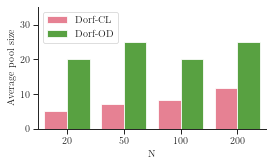

In [47]:
utils.latexify(font_size=10)

fig_height, fig_aspect = get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_height*fig_aspect,fig_height))

sns.barplot(data=size_df, x="N", y="Average pool size", hue="method", ci=None, 
            palette=[palette[0]]+[palette[2]], hue_order=['binomial', 'negbin'], ax=ax)
sns.despine()

ax.legend(labels=['Dorf-CL', 'Dorf-OD'], loc='upper left')
ax.set_ylim([0,35])

fig.tight_layout()
fig.savefig('figures/{name}_pool_size_se_{se}_sp_{sp}.pdf'.format(name=name, se=se, sp=sp))

In [48]:
perc_df = total_df.pivot(index=['lambda_1', 'lambda_2', 'se', 'sp', 'r', 'k', 'seed', 'N'], columns='method', values='num_of_tests').reset_index()
perc_df['Perc'] = 100*(perc_df['binomial'] - perc_df['negbin'])/perc_df['binomial']

df_list = []
means = []
for N in [20, 50, 100, 200]:
    temp_df = perc_df[(perc_df['N']==N)].sort_values(by=['Perc'])
    means.append(temp_df['Perc'].mean())
    num_of_rows_to_skip = int(0.05 * temp_df.shape[0])
    temp_df = temp_df.iloc[num_of_rows_to_skip:-num_of_rows_to_skip]
    
    df_list.append(temp_df)

perc_df = pd.concat(df_list)

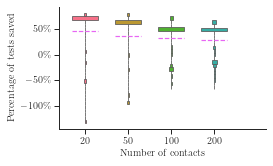

In [49]:
utils.latexify(font_size=10)

fig_height, fig_aspect = get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_height*fig_aspect,fig_height))

# Adapted from https://matplotlib.org/stable/gallery/statistics/multiple_histograms_side_by_side.html

labels = perc_df['N'].unique()
# data_sets = [tests_df[(tests_df['Number of contacts']==N) & (tests_df['Perc'] < tests_df['Perc'].quantile(.95)) & (tests_df['Perc'] > tests_df['Perc'].quantile(.05))]['Perc'].to_numpy() for N in labels]
data_sets = [perc_df[perc_df['N']==N]['Perc'].to_numpy() for N in labels]

hist_range = (np.min(data_sets), np.max(data_sets))
number_of_bins = 30
binned_data_sets=[]
for d in data_sets:
    hist = np.histogram(d, range=hist_range, bins=number_of_bins)[0]
    hist_max = np.max(hist)
    binned_data_sets.append(hist/hist_max)

binned_data_sets = np.array(binned_data_sets)

x_locations = np.linspace(0, len(binned_data_sets)+1, len(binned_data_sets))

i=0
for x_loc, binned_data in zip(x_locations, binned_data_sets):
    non_zero = np.nonzero(binned_data)[0]
    effective_range_ids = non_zero[0], non_zero[-1]
    effective_bins = non_zero[-1] - non_zero[0] + 1
    effective_range = hist_range[0]+non_zero[0]*(hist_range[1]-hist_range[0])/number_of_bins, \
                        hist_range[0]+non_zero[-1]*(hist_range[1]-hist_range[0])/number_of_bins

    bin_edges = np.linspace(effective_range[0], effective_range[1], effective_bins+1)
    centers = 0.5 * (bin_edges + np.roll(bin_edges, 1))[1:]
    
    heights = np.diff(bin_edges)
    # lefts = x_loc - 0.5 * binned_data
    lefts = x_loc - 0.5 * binned_data[effective_range_ids[0]:effective_range_ids[1]+1]
    rights = x_loc + 0.5 * binned_data[effective_range_ids[0]:effective_range_ids[1]+1]
    
    ax.barh(centers, binned_data[effective_range_ids[0]:effective_range_ids[1]+1], height=heights, left=lefts, color=palette[i], edgecolor='#595959')
    
    ax.hlines(y=means[i], xmin=min(lefts), xmax=max(rights), linestyles='dashed', colors=palette[5])

    i += 1

sns.despine()
ax.set_xticks(x_locations)
ax.set_xticklabels(labels)

ax.set_ylabel(r'Percentage of tests saved', loc='center')
ax.set_xlabel("Number of contacts")
ax.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter())
# ax.set_ylim([-2, 1])
ax.set_xlim([-1, 7])

fig.tight_layout()
fig.savefig('figures/{name}_percentage_se_{se}_sp_{sp}.pdf'.format(name=name, se=se, sp=sp))